In [1]:
# Import necessary libraries for file handling, data manipulation, and visualization
import os 
import random
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for working with images and transformations
from PIL import Image
import cv2 as cv

# Import PyTorch modules for model building, data handling, and evaluation
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

# Import libraries for machine learning metrics and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import torchmetrics
from tqdm import tqdm

In [2]:
data_dir = "C:\\Users\\sebastian.cruz6\\Workspace\\Research\\CAWT-URFI\\cp-anemia-detection\\data\\cp-anemia\\"
anemic_dir = data_dir+"Anemic\\"
non_anemic_dir = data_dir+"Non-anemic\\"

data_sheet_path = data_dir+"Anemia_Data_Collection_Sheet.csv"
data_sheet = pd.read_csv(data_sheet_path)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana
...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana


In [3]:
# Mapping diagnosis to severity
severity_mapping = {
    "Non-Anemic": [1,0,0,0],
    "Mild": [0,1,0,0],
    "Moderate": [0,0,1,0],
    "Severe": [0,0,0,1],
}

data_sheet['SEVERITY_ONEHOT'] = data_sheet['Severity'].map(severity_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]"
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]"
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]"
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]"
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]"


In [4]:
# Mapping diagnosis to severity
remark_mapping = {
    "Non-anemic": 0,
    "Anemic": 1
}

data_sheet['REMARK_ONEHOT'] = data_sheet['REMARK'].map(remark_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT,REMARK_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]",1
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]",1
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]",0
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0


In [5]:
device = torch.device('cpu')

# Default device
device = torch.device('cpu')

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("CUDA is not available, using CPU.")

print(f"Selected device: {device}")

CUDA is not available, using CPU.
Selected device: cpu


In [6]:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((256,192)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets from CSV files (assuming you have a custom dataset class)
class DRImageDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        """
        Initializes the dataset with a directory and DataFrame, and optional transformations.
        
        Parameters:
        dir (str): Path to the directory containing images.
        df (DataFrame): DataFrame containing image IDs and labels.
        transform (callable, optional): Optional transformations to be applied to the images.
        """
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        int: Number of samples.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        
        Parameters:
        idx (int): Index of the sample to retrieve.
        
        Returns:
        tuple: (image, target, description) where image is the transformed image, target is the label, and description is the severity description.
        """
        row = self.df.iloc[idx]
        img_id = row['IMAGE_ID']
        img_folder = row['REMARK']
        img_path = os.path.join(self.dir, img_folder, img_id + ".png")
        # print(img_path)
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(row['REMARK_ONEHOT'], dtype=torch.int64)
        # print(img.size())
        # print(img)
        # print(label.size())
        # print(label)
        descriptor = img_folder
        
        return img, label, descriptor

# Create the dataset
image_dataset = DRImageDataset(data_dir, data_sheet, transform=transform)
# image_dataset = DRImageDataset(data_dir, sample_df, transform=transform)

# Split the dataset
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.3, shuffle=True)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, shuffle=True)

print(f"Train Dataset: {len(train_dataset)}, Val Dataset:{len(val_dataset)}, Test Dataset: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Dataset: 497, Val Dataset:106, Test Dataset: 107


In [7]:
def train(dataloader, model, loss_fn, optimizer, cumulative_metrics):
    """
    Training loop for one epoch.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the training data.
    model (torch.nn.Module): PyTorch model to be trained.
    loss_fn (callable): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the epoch.
    """
    model.train()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []
    cumulative_metrics.reset()

    for _, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y = y.to(torch.float32)
        
        optimizer.zero_grad()
        pred = model(X)

        # logits = model(X)
        # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
        # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
        # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding

        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())        
        cumulative_metrics.update(pred, y)
    
    avg_loss = sum(batch_losses) / len(batch_losses)    
    performance_metrics = cumulative_metrics.get_cumulative_metrics()

    return avg_loss, performance_metrics

def eval(dataloader, model, loss_fn, mode, cumulative_metrics):
    """
    Testing loop to evaluate the model on the test dataset.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the test data.
    model (torch.nn.Module): PyTorch model to be evaluated.
    loss_fn (callable): Loss function.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the test dataset.
    """
    model.eval()
    size = len(dataloader.dataset)
    batch_losses = []
    cumulative_metrics.reset()

    if mode == "Testing":
        with torch.no_grad():
            for _, (X, y, _) in enumerate(dataloader):
                X, y = X.to(device), y.to(device).unsqueeze(1)
                y = y.to(torch.float32)

                pred = model(X)
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()

    
    if mode == "Validation":
        with torch.no_grad():
            for _, (X, y, _) in enumerate(dataloader):
                X, y = X.to(device), y.to(device).unsqueeze(1)
                y = y.to(torch.float32)

                pred = model(X)
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()
    
    return avg_loss, performance_metrics

In [8]:
import torch
import torchmetrics
from sklearn.metrics import roc_auc_score

class CumulativeMetrics:
    def __init__(self):
        # Initialize torchmetrics for binary classification
        self.accuracy = torchmetrics.Accuracy(task="binary").to(device)
        self.precision = torchmetrics.Precision(task="binary", average="macro").to(device)
        self.recall = torchmetrics.Recall(task="binary", average="macro").to(device)
        self.f1_score = torchmetrics.F1Score(task="binary", average="macro").to(device)

        # For scikit-learn metrics, we'll store the true and predicted values for each batch
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

        self.reset()

    def reset(self):
        # Reset torchmetrics accumulators
        self.cum_acc = 0.0
        self.cum_prec = 0.0
        self.cum_rec = 0.0
        self.cum_f1 = 0.0
        self.num_batches = 0
        
        # Reset true and predicted values lists for sklearn
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # For binary classification, y_true is already a class label (0 or 1)
        y_pred_class = torch.round(torch.sigmoid(y_pred)).int()  # Get predicted class by rounding sigmoid output

        # Append predictions and true labels for scikit-learn metrics later
        self.y_true_all.extend(y_true.cpu().numpy())
        self.y_pred_all.extend(y_pred_class.cpu().numpy())
        self.y_score_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy())  # Probabilities/logits for AUC

        # Update cumulative torchmetrics
        acc = self.accuracy(y_pred_class, y_true).item()
        prec = self.precision(y_pred_class, y_true).item()
        rec = self.recall(y_pred_class, y_true).item()
        f1 = self.f1_score(y_pred_class, y_true).item()

        self.cum_acc += acc
        self.cum_prec += prec
        self.cum_rec += rec
        self.cum_f1 += f1
        self.num_batches += 1

    def get_cumulative_metrics(self):
        avg_acc = self.cum_acc / self.num_batches
        avg_prec = self.cum_prec / self.num_batches
        avg_rec = self.cum_rec / self.num_batches
        avg_f1 = self.cum_f1 / self.num_batches

        # Ensure y_true_all contains basic data types before using set
        y_true_list = [int(val) for val in self.y_true_all]

        # Compute AUC using sklearn
        if len(self.y_score_all) > 0 and len(set(y_true_list)) > 1:
            auc = roc_auc_score(self.y_true_all, self.y_score_all)
        else:
            auc = None  # If no valid score or only one class present

        performance_metrics = {
            "Accuracy": avg_acc,
            "Precision": avg_prec,
            "Recall": avg_rec,
            "F1 Score": avg_f1,
            "AUC": auc,
        }        
        return performance_metrics


In [9]:
# Load MobileNetV2 with pretrained weights disabled
# mbnetv2 = models.mobilenet_v2(weights="IMAGENET1K_V2")
mbnetv2 = models.mobilenet_v2(weights=None)

# Modify the classifier to output 5 classes (corresponding to the severity levels)
mbnetv2.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
mbnetv2 = mbnetv2.to(device)

# Print the model summary
print(summary(mbnetv2))

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [10]:
import torch
from torch.utils.data import Subset
from sklearn.model_selection import KFold
from tqdm import tqdm

# Assuming `CumulativeMetrics` is already implemented elsewhere
cumulative_metrics = CumulativeMetrics()  # Instance to track metrics (accuracy, precision, etc.)

# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((256,192)),
    transforms.RandomHorizontalFlip(p=np.random.rand()),
    transforms.RandomVerticalFlip(p=np.random.rand()),
    transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.RandomAffine(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class DRImageDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['IMAGE_ID']
        img_folder = row['REMARK']
        img_path = os.path.join(self.dir, img_folder, img_id + ".png")
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(row['REMARK_ONEHOT'], dtype=torch.int64)
        descriptor = img_folder
        
        return img, label, descriptor

# Load the dataset
image_dataset = DRImageDataset(data_dir, data_sheet, transform=transform)

train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.15, shuffle=True)

# Iterate over each fold
EPOCHS = 150
FOLDS = 5

# 5-fold cross-validation setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Initialize model, loss function, and optimizer
model = mbnetv2  # Your model instance
loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary cross-entropy loss (modify according to your task)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)  # Adam optimizer (example)

# Path where the model with the best precision is saved
weights_path = "C:\\Users\\sebastian.cruz6\\Workspace\\Research\\CAWT-URFI\\cp-anemia-detection\\notebooks\\weights"

best_val_f1score = -float('inf')  # Initialize with a very low value

train_metrics_df = []
val_metrics_df = []

for epochs in range(EPOCHS):
    print(f"\nEpoch {epochs+1}/{EPOCHS}")
    fold = 1
    fold_best_train_f1score = -float('inf')

    for train_idx, val_idx in kf.split(train_dataset):
        # Create subset datasets for training and validation
        train_subset = Subset(image_dataset, train_idx)
        val_subset = Subset(image_dataset, val_idx)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        if fold == FOLDS:
            # Validation loop
            avg_val_loss, val_metrics = eval(val_loader, model, loss_fn, mode="Validation", cumulative_metrics=cumulative_metrics)
            avg_val_accuracy, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_auc = val_metrics.values()

            print(f"\nValidation: \tFold {fold} - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, F1 Score: {avg_val_f1:.4f}, AUC Score: {avg_val_auc:.4f}")

            # Save the best model based on validation precision
            if avg_val_f1 > best_val_f1score:
                best_val_f1score = avg_val_f1
                
                val_metrics_dict = {**{"Loss":avg_val_loss}, **val_metrics}
                val_metrics_df.append(val_metrics_dict)

                torch.save(mbnetv2.state_dict(), f'{weights_path}\\mbnetv2_best_f1score.pth')
                print(f"Model with best precision during Validation saved at epoch {epochs + 1} with F1 Score of {best_val_f1score:.4f}")
        # """
        # Implement early stopping here as an elif statement
        # """
        else:
            # Training loop
            avg_train_loss, train_metrics = train(train_loader, model, loss_fn, optimizer, cumulative_metrics)
            avg_train_accuracy, avg_train_precision, avg_train_recall, avg_train_f1, avg_train_auc = train_metrics.values()

            if avg_train_f1 > fold_best_train_f1score:
                fold_best_train_f1score = avg_train_f1

                print(f"Training: \tFold {fold} - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}, Precision: {avg_train_precision:.4f}, Recall: {avg_train_recall:.4f}, F1 Score: {avg_train_f1:.4f}, AUC Score: {avg_train_auc:.4f}")
                train_metrics_dict = {**{"Loss":avg_train_loss}, **train_metrics}
                train_metrics_df.append(train_metrics_dict)

        # Reset metrics and model (if needed) for next fold
        cumulative_metrics.reset()

        fold += 1



Epoch 1/150
Training: 	Fold 1 - Loss: 0.7246, Accuracy: 0.5371, Precision: 0.5155, Recall: 0.6768, F1 Score: 0.5649, AUC Score: 0.5306
Training: 	Fold 2 - Loss: 0.7178, Accuracy: 0.5293, Precision: 0.5953, Recall: 0.6410, F1 Score: 0.5819, AUC Score: 0.4962
Training: 	Fold 3 - Loss: 0.7029, Accuracy: 0.5918, Precision: 0.6115, Recall: 0.8656, F1 Score: 0.7078, AUC Score: 0.5171

Validation: 	Fold 5 - Loss: 0.6822, Accuracy: 0.5807, Precision: 0.5807, Recall: 1.0000, F1 Score: 0.7163, AUC Score: 0.6314
Model with best precision during Validation saved at epoch 1 with F1 Score of 0.7163

Epoch 2/150
Training: 	Fold 1 - Loss: 0.6811, Accuracy: 0.5430, Precision: 0.5816, Recall: 0.6158, F1 Score: 0.5696, AUC Score: 0.5166
Training: 	Fold 2 - Loss: 0.7148, Accuracy: 0.5898, Precision: 0.6048, Recall: 0.9363, F1 Score: 0.7268, AUC Score: 0.4645

Validation: 	Fold 5 - Loss: 0.6661, Accuracy: 0.6250, Precision: 0.7091, Recall: 0.5922, F1 Score: 0.6316, AUC Score: 0.6846

Epoch 3/150
Training:

In [30]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
mbnetv2.load_state_dict(torch.load(f'{weights_path}\\mbnetv2_best_f1score.pth', weights_only=True))

test_loss, test_performance_metrics = eval(test_loader, mbnetv2, loss_fn, 'Testing', CumulativeMetrics())
test_accuracy, test_precision, test_recall, test_f1, test_auc = test_performance_metrics.values()
print(f"Testing: \tLoss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUC Score: {test_auc:.4f}")

Testing: 	Loss: 0.1412, Accuracy: 0.9531, Precision: 0.9821, Recall: 0.9275, F1 Score: 0.9535, AUC Score: 0.9920


In [32]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
mbnetv2.load_state_dict(torch.load(f'{weights_path}\\mbnetv2_best_f1score.pth', weights_only=True))

K_ITER = 100
test_metrics_df = []

for k in range(K_ITER):
    test_loss, test_performance_metrics = eval(test_loader, mbnetv2, loss_fn, 'Testing', CumulativeMetrics())
    test_metrics_dict = {**{"Loss":test_loss}, **test_performance_metrics}
    test_metrics_df.append(test_metrics_dict)

test_metrics_df = pd.DataFrame(test_metrics_df)
display(test_metrics_df.sort_values(by=['Accuracy'], ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
0,0.143646,0.953125,0.989130,0.934028,0.960233,0.992006
18,0.137560,0.953125,0.988636,0.933036,0.958289,0.992006
53,0.149667,0.953125,0.988095,0.943582,0.964773,0.992006
69,0.139707,0.953125,0.988095,0.941558,0.963327,0.992006
54,0.143856,0.953125,0.988095,0.938797,0.962554,0.992006
13,0.136605,0.953125,0.988095,0.937799,0.961912,0.992006
55,0.143740,0.953125,0.988095,0.934789,0.960277,0.992006
30,0.138522,0.953125,0.988095,0.934058,0.959416,0.992006
89,0.152075,0.953125,0.987500,0.942100,0.963690,0.992006
63,0.147333,0.953125,0.987500,0.938045,0.961858,0.992006


In [20]:
def print_model_size(title, mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print(title, "%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

print_model_size("MobileNetV2 w/ Pre-trained Weights (ImageNet1K) Trained on CP-AnemiC Dataset:", mbnetv2)

MobileNetV2 w/ Pre-trained Weights (ImageNet1K) Trained on CP-AnemiC Dataset: 9.12 MB


In [21]:
train_metrics_df = pd.DataFrame(train_metrics_df)
display(train_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
326,0.228302,0.927734,0.939630,0.940277,0.937690,0.973277
345,0.211116,0.927734,0.937304,0.946870,0.939360,0.975513
318,0.218703,0.921875,0.916300,0.958114,0.934544,0.970280
329,0.256623,0.919922,0.932408,0.937058,0.932733,0.959023
333,0.220126,0.919922,0.919517,0.948818,0.932327,0.975279
280,0.246095,0.908203,0.923514,0.926420,0.921794,0.959583
260,0.260868,0.908203,0.929909,0.921903,0.922706,0.961028
337,0.242780,0.908203,0.901709,0.952591,0.924911,0.965838
313,0.248252,0.902344,0.911365,0.926339,0.916866,0.961164
338,0.273219,0.902344,0.923812,0.916529,0.916706,0.950603


In [22]:
val_metrics_df = pd.DataFrame(val_metrics_df)
display(val_metrics_df.sort_values(by='Accuracy', ascending=False)[:25])

,Loss,Accuracy,Precision,Recall,F1 Score,AUC
11,0.105029,0.976562,0.979167,0.974074,0.975793,0.998011
8,0.178802,0.968750,0.942308,0.977273,0.958333,0.992327
10,0.122506,0.966146,0.939907,1.000000,0.968945,0.994885
7,0.191558,0.960938,0.930288,0.983333,0.954973,0.984086
9,0.129773,0.955729,0.979167,0.942824,0.959126,0.994885
6,0.291543,0.880208,0.875000,0.914005,0.885317,0.951691
5,0.558716,0.843750,0.792579,0.935722,0.853199,0.884342
4,0.400239,0.833333,0.797153,0.920097,0.848680,0.907360
2,0.505436,0.786458,0.758750,0.878851,0.804692,0.806195
3,0.550573,0.765625,0.746377,0.940972,0.806722,0.783745


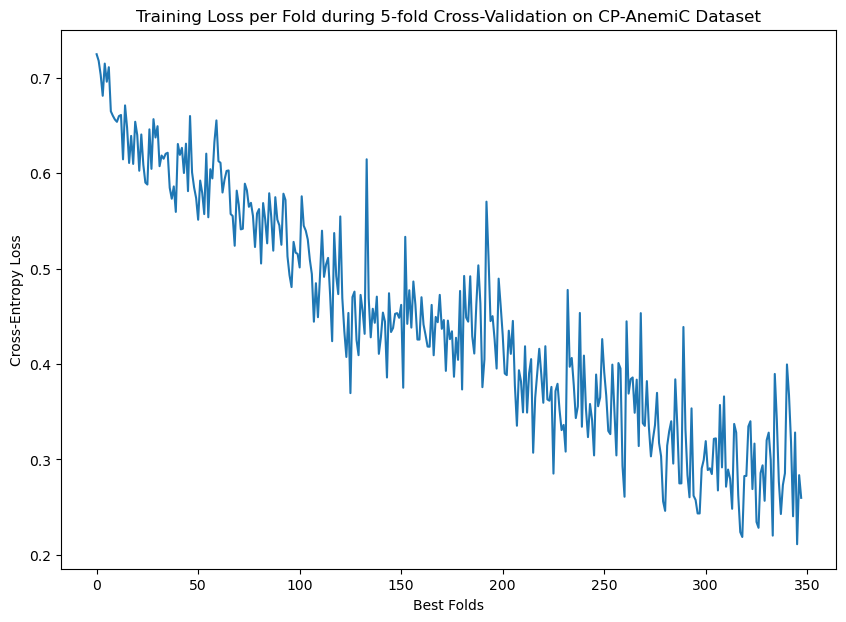

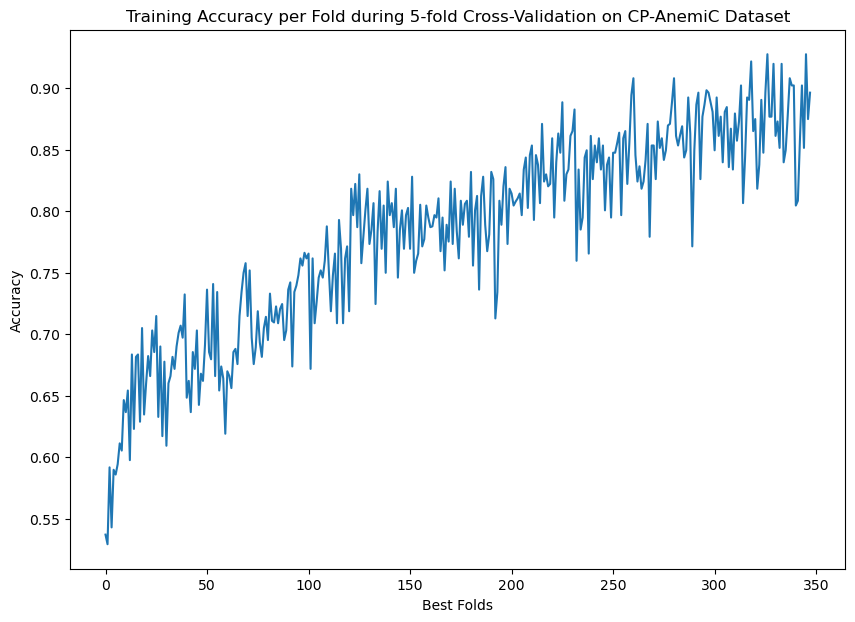

In [23]:
plt.figure(figsize=(10,7))
train_loss_df = train_metrics_df["Loss"]
plt.plot(range(len(train_loss_df)), train_loss_df)
plt.title("Training Loss per Fold during 5-fold Cross-Validation on CP-AnemiC Dataset")
plt.xlabel("Best Folds")
plt.ylabel("Cross-Entropy Loss")
plt.show()

plt.figure(figsize=(10,7))
train_acc_df = train_metrics_df["Accuracy"]
plt.plot(range(len(train_acc_df)), train_acc_df)
plt.title("Training Accuracy per Fold during 5-fold Cross-Validation on CP-AnemiC Dataset")
plt.xlabel("Best Folds")
plt.ylabel("Accuracy")
plt.show()

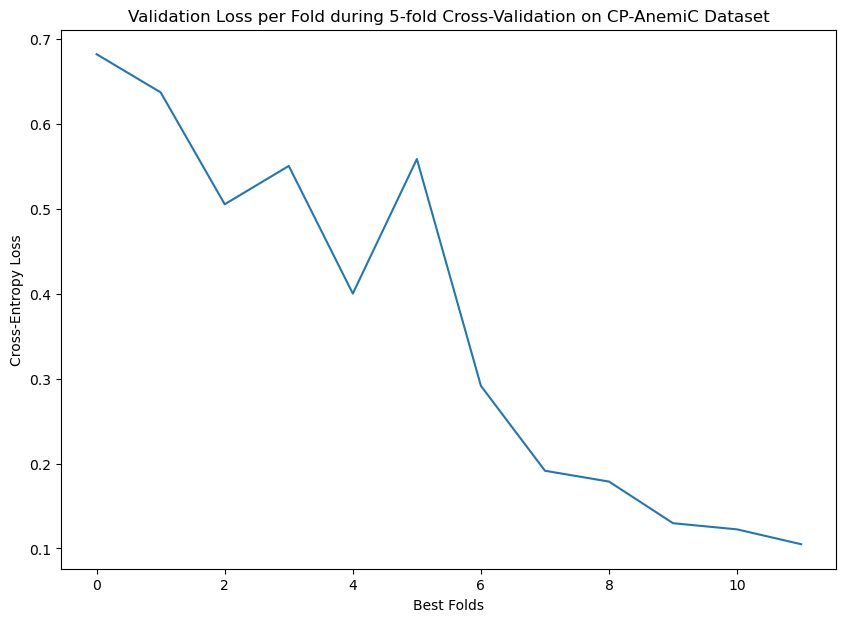

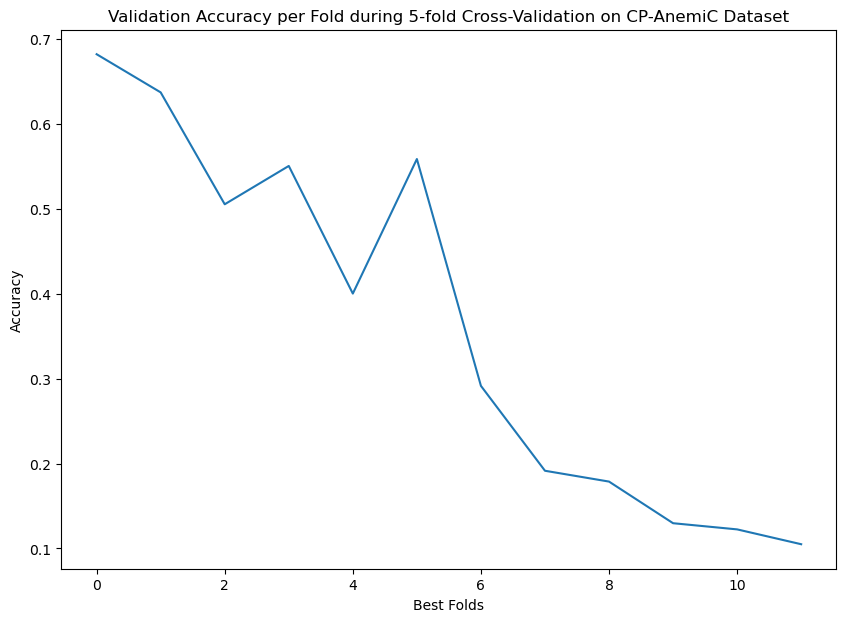

In [24]:
plt.figure(figsize=(10,7))
val_loss_df = val_metrics_df["Loss"]
plt.plot(range(len(val_loss_df)), val_loss_df)
plt.title("Validation Loss per Fold during 5-fold Cross-Validation on CP-AnemiC Dataset")
plt.xlabel("Best Folds")
plt.ylabel("Cross-Entropy Loss")
plt.show()

plt.figure(figsize=(10,7))
val_acc_df = val_metrics_df["Loss"]
plt.plot(range(len(val_acc_df)), val_acc_df)
plt.title("Validation Accuracy per Fold during 5-fold Cross-Validation on CP-AnemiC Dataset")
plt.xlabel("Best Folds")
plt.ylabel("Accuracy")
plt.show()
